In [94]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pf
import os
import glob
# This makes nice big plots 
import matplotlib as mpl
params = {'font.size'     : 14,
          'figure.figsize':(15.0, 8.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,
          'animation.embed_limit': 2048,
          }
mpl.rcParams.keys()
mpl.rcParams.update(params)
np.set_printoptions(suppress=True)




## Animate not projected SHARPS

In [2]:
#Load not processed SHARPS filenames into list
data_dir_NP = os.path.abspath("/home/lazar/Fak(s)/AF/prakse/SDSA/data/3481_11923_SHARP_NP")
data_list_NP = sorted(glob.glob(os.path.join(data_dir_NP,'*continuum*')))


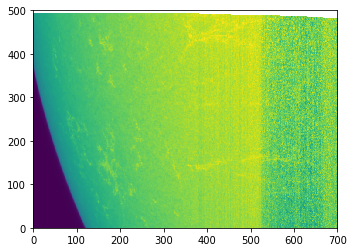

In [3]:
#3rd party library that is wrapper for matplotlib animate (works with ffmpeg)

#actuall animation process
from celluloid import Camera
#Create placeholders for canvas
fig, ax = plt.subplots()
camera = Camera(fig)
#Fix canvas size (because data dimension changes with time)
ax.set_xlim(0,700)
ax.set_ylim(0,500)
for i in data_list_NP:
    hdu = pf.open(i)
    hdu.verify('silentfix')
    plt.imshow(hdu[1].data)
    camera.snap()

#Uncomment this if you want to save .mp4 file
#animation = camera.animate(interval=30)
#animation.save('4381_raw.mp4')


#uncomment this for live preview in jupyter notebook
#from IPython.display import HTML
#HTML(animation.to_html5_video())



## Animate projected SHARPS (same procedure as above, but different filenames)

In [4]:
#Load projected SHARPS
data_dir_CEA = os.path.abspath("/home/lazar/Fak(s)/AF/prakse/SDSA/data/3481_11923_SHARP_CEA")
data_list_CEA = sorted(glob.glob(os.path.join(data_dir_CEA,'*continuum*')))

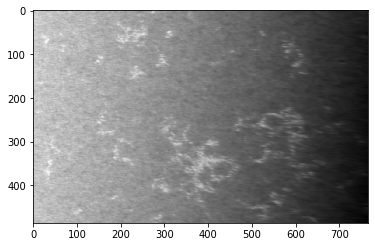

In [5]:
fig1, ax1 = plt.subplots()
camera1 = Camera(fig1)
for i in data_list_CEA:
    hdu = pf.open(i)
    hdu.verify('silentfix')
    plt.imshow(hdu[1].data, cmap='gray')
    #print(hdu[1].data.shape)
    camera1.snap()

#animation1 = camera1.animate(interval=30)
#animation1.save('4381_CEA.mp4')

#from IPython.display import HTML
#HTML(animation1.to_html5_video())


## Remove limb darkening using SVD (singular value decomposition) on near limb image


/home/lazar/Fak(s)/AF/prakse/SDSA/data/3481_11923_SHARP_CEA/hmi.sharp_cea_720s.3481.20131208_111200_TAI.continuum.fits


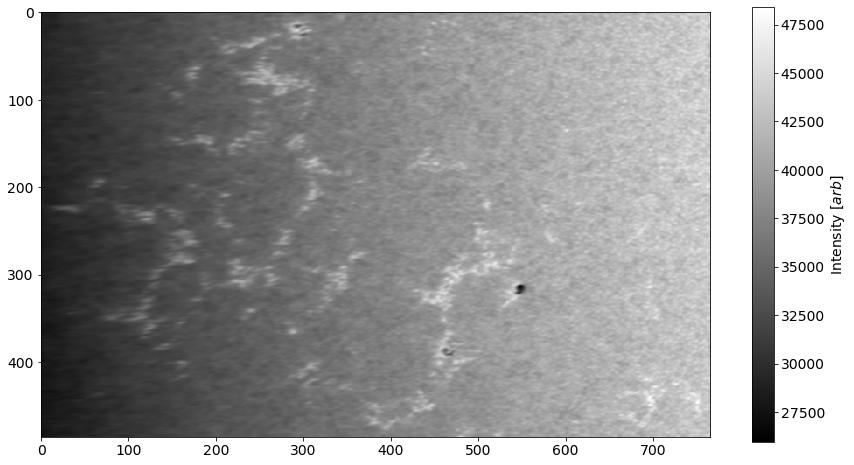

In [59]:
#Use first image in dataset, near the limb
img_file = data_list_CEA[0]
print(data_list_CEA[0])

#Read fits file
img_hdu = pf.open(img_file)
img_hdu.verify('silentfix')
#Extract only data for easier manipulation
img_data = img_hdu[1].data
#Plot it
plt.imshow(img_data, cmap='gray')
plt.colorbar(label=r'Intensity $[arb]$')

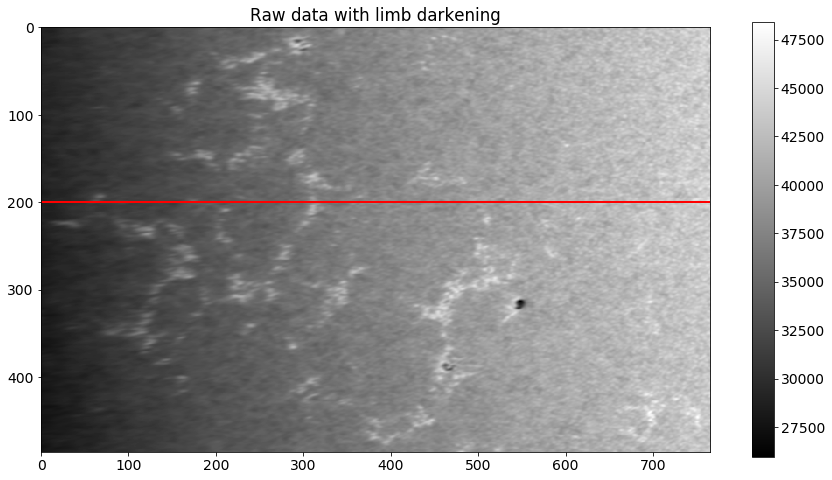

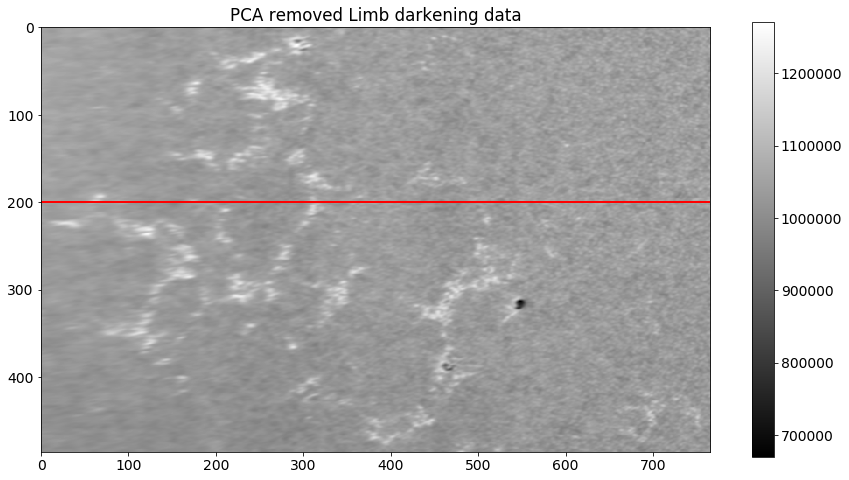

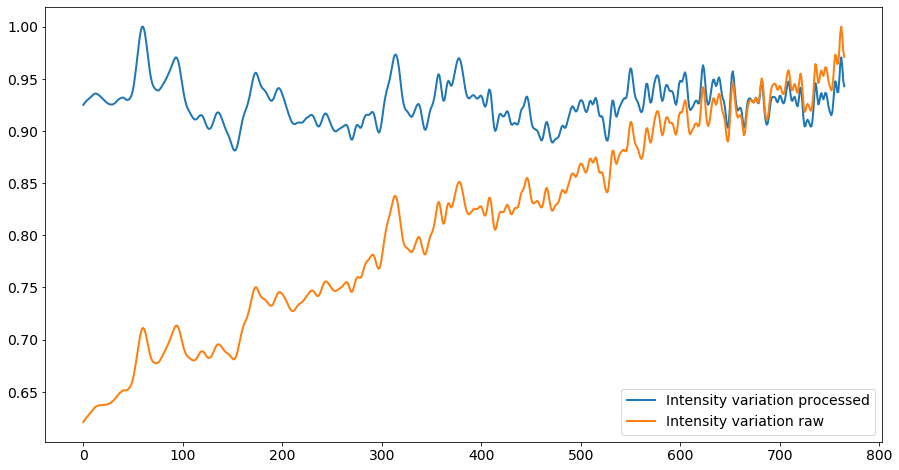

In [116]:
#Import sincular value decomposition function from scipy
#Read docs here https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
from scipy.linalg import svd
decompose = svd(img_data)

#Use first component of left singular vector (main variation)
vector_pca = np.abs(vectors[0,:])

#Plot image with red line that is used for intensity comparison after PCA
plt.figure(0)
plt.imshow(img_data, cmap='gray')
plt.axhline(200, color='r', linestyle='-')
plt.title('Raw data with limb darkening')
plt.colorbar()

#Plot corrected image
plt.figure(1)
#Divide whole image row by row with first component of left singular vector 
removed_limb = img_data/vector_pca[None,:]
plt.imshow(removed_limb, cmap='gray')
plt.axhline(200, color='r', linestyle='-')
plt.title('PCA removed Limb darkening data')
plt.colorbar()


#Plot intensity variation between images
plt.figure(2)
plt.plot(removed_limb[200,:]/np.max(removed_limb[200,:]), label='Intensity variation processed')
plt.plot(img_data[200,:]/np.max(img_data[200,:]), label='Intensity variation raw')
plt.legend()



## Remove limb darkening using SVD (singular value decomposition) on disk center image

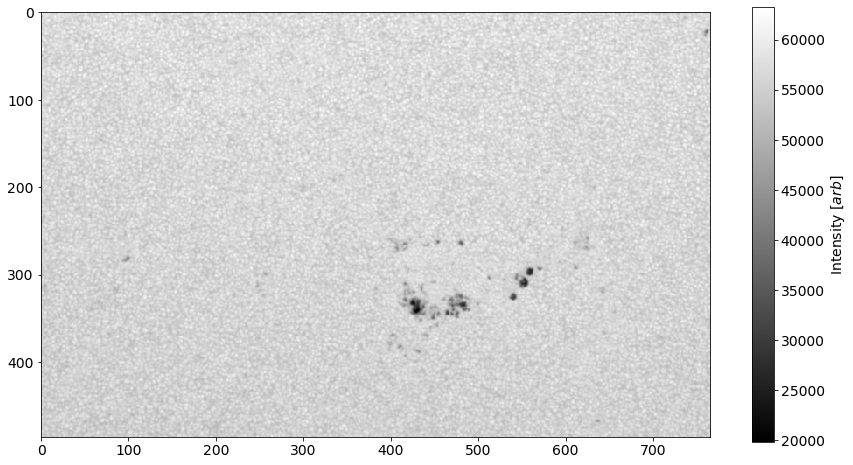

In [117]:
#Same as above but with region near disk center

img_file = data_list_CEA[600]
#print(data_list_CEA[0])
img_hdu = pf.open(img_file)
img_hdu.verify('silentfix')
img_data = img_hdu[1].data
plt.imshow(img_data, cmap='gray')
plt.colorbar(label=r'Intensity $[arb]$')

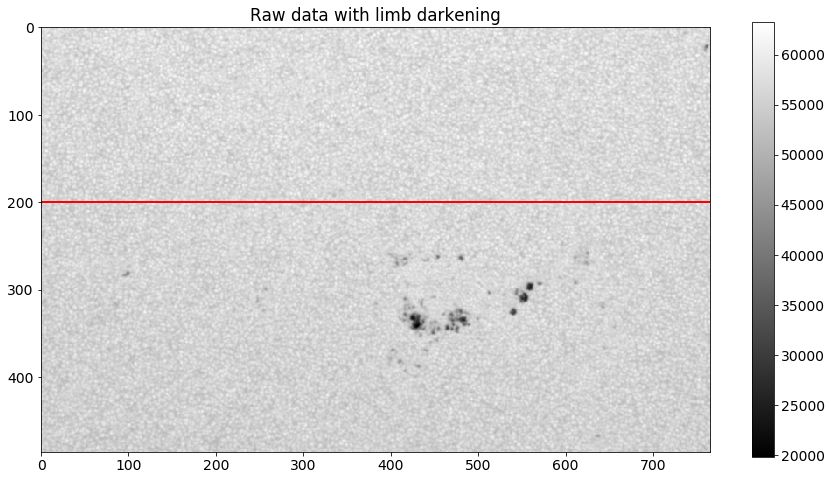

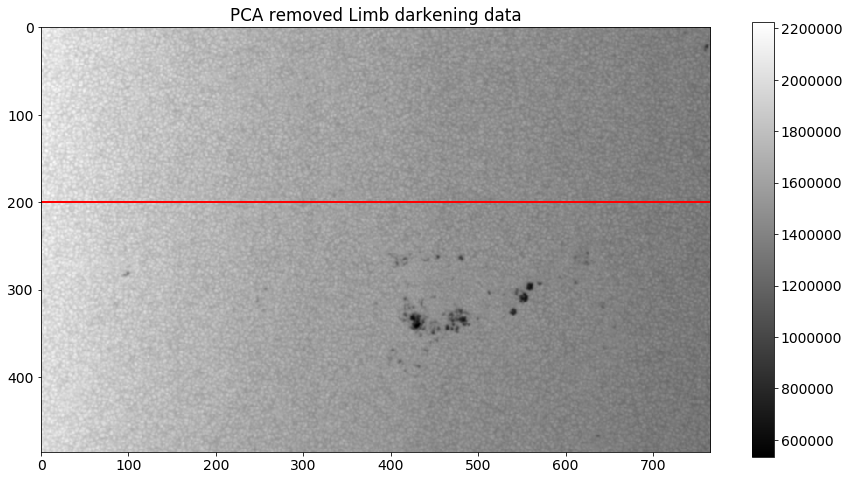

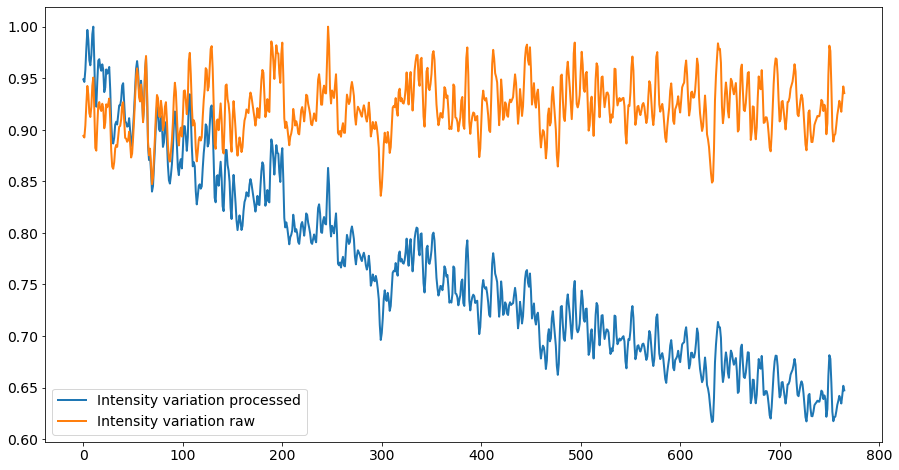

In [118]:
vector_pca = np.abs(vectors[0,:])
plt.figure(0)
plt.imshow(img_data, cmap='gray')
plt.axhline(200, color='r', linestyle='-')
plt.title('Raw data with limb darkening')
plt.colorbar()
plt.figure(1)
removed_limb = img_data/vector_pca[None,:]
plt.imshow(removed_limb, cmap='gray')
plt.axhline(200, color='r', linestyle='-')
plt.title('PCA removed Limb darkening data')
plt.colorbar()
plt.figure(2)
plt.plot(removed_limb[200,:]/np.max(removed_limb[200,:]), label='Intensity variation processed')
plt.plot(img_data[200,:]/np.max(img_data[200,:]), label='Intensity variation raw')
plt.legend()

Idea is that because there is no obvious intensity gradient, primary component of SVD is not actually limb darkening but some small scale variation across image. This leads to adding some artifacts that are not related to limb darkening, so this method is not suitable for removing limb darkening near disk center. Better idea is to create limb darkening function for this specific filter using some curve $f(r,\lambda)$, where $r$ is distance from disk center, and find $r$ for every pixel and reduce it that way.